In [1]:
import os
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
DATASET_ROOT = Path('/data/flybyml_dataset_v1')
data_root = DATASET_ROOT / "data"
meta_root = DATASET_ROOT / "meta"

# collect all possible session ids
session_ids = set()

for data_file in os.listdir(data_root):
    session_id = data_file.split(".")[0]
    session_ids.add(session_id)

for meta_file in os.listdir(meta_root):
    session_id = meta_file.split(".")[0]
    session_ids.add(session_id)

session_ids = list(session_ids)

def load_data(session_id):
    with open(data_root / f"{session_id}.json", "r") as f:
        return json.load(f)

def load_meta(session_id):
    with open(meta_root / f"{session_id}.json", "r") as f:
        return json.load(f)

In [3]:
data = [load_data(session_id) for session_id in session_ids]
meta = [load_meta(session_id) for session_id in session_ids]

In [4]:
trajectories = []
for d, m in zip(data, meta):
    try:
        rwy_heading = np.deg2rad(m['target_rwy']['attitude'][2])
        rotation_mat = np.array([[np.cos(-rwy_heading), -np.sin(-rwy_heading)],
                                 [np.sin(-rwy_heading), np.cos(-rwy_heading)]])
        abs_pos = []
        for datum in d:
            abs_pos.append(datum['state']['position'])
        abs_pos = np.array(abs_pos)
        rwy_pos = np.array(m['target_rwy']['position'])
        pos_diff = (abs_pos - rwy_pos)[:, :2]
        altitude = (abs_pos - rwy_pos)[:,2]
        
        # trajectory (x, y, z) and timestamps
        traj_xy = np.matmul(rotation_mat, pos_diff.T)   # (2, 2333)
        traj_xyz = np.vstack([traj_xy, altitude])       # (3, 2333)
        trajectories.append(traj_xyz)
    except:
        pass
trajectories[0].shape

(3, 2387)

### Animate one sample

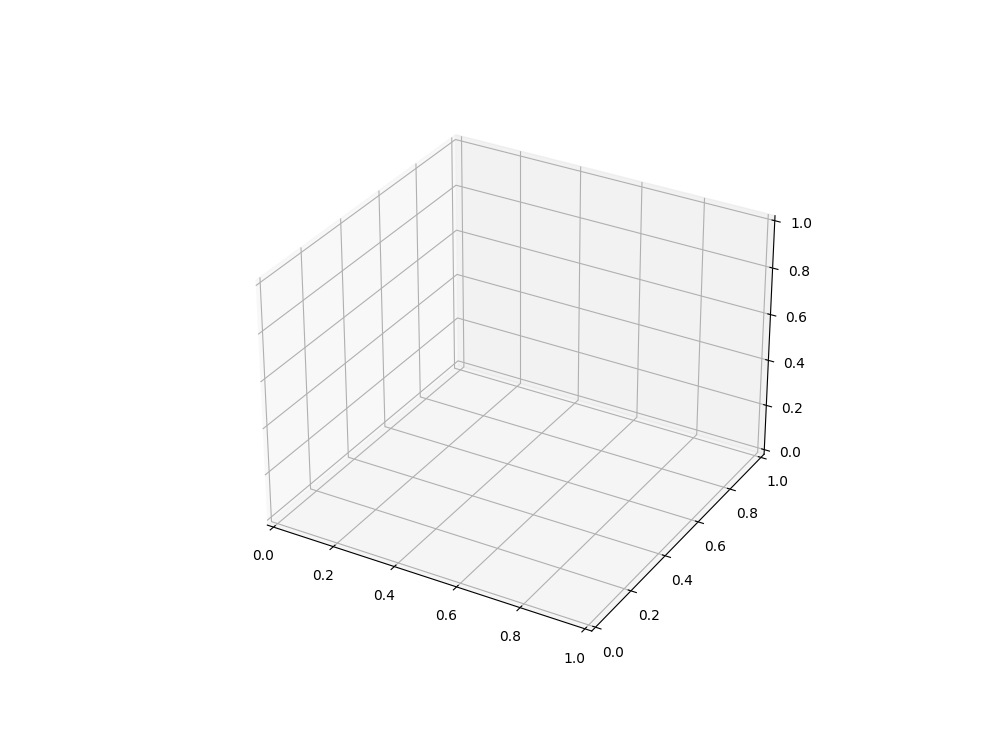

In [5]:
fig = plt.figure(figsize=(10, 10*(3/4)))
ax = fig.add_subplot(111, projection='3d')

traj = trajectories[0]

# Animation Update Function
def update(frame):
    ax.cla() 
    ax.plot(traj[0][:frame], traj[1][:frame], traj[2][:frame], linewidth=2)
    ax.set_title('position distribution')
    ax.set_xlim((-0.4, 0.4))
    ax.set_ylim((-0.3, 0.3))
    ax.set_zlim((0, 1400))
    return ax,

def init():
    ax.set_title('position distribution')
    ax.set_xlim((-0.4, 0.4))
    ax.set_ylim((-0.3, 0.3))
    ax.set_zlim((0, 1400))
    return ax,

ani = FuncAnimation(fig, update, frames=range(1, traj.shape[1]), init_func=init, blit=False)

plt.show()

In [7]:
ani.save('trajectory.gif', writer='imagemagick', fps=30, dpi=100)

MovieWriter imagemagick unavailable; using Pillow instead.
